<p align="center">
  <img src="images\Hub_title.png" alt="[YOUR_IMAGE_ALT]">
</p>

## ***Business Understanding***

### *Overview*
Tourism is a thriving industry in Kenya, and travelers often face the challenge of choosing the right destinations for their trips. Our project aims to address this problem by creating a recommendation system that assists users in discovering personalized tourist destinations in the country.

### *Problem Statement*

Travelers often struggle to choose the most suitable tourist destinations for their trips. With an overwhelming number of options available, personalized recommendations are crucial. Our project aims to address this challenge by creating a recommendation system that suggests relevant destinations in Kenya based on user preferences and historical interactions.

#### *Stakeholders*
1. **Travelers**: They seek relevant recommendations based on their preferences, interests, and historical interactions.
2. **Tourism Agencies**: These organizations can enhance user experiences by providing tailored suggestions.
3. **Local Businesses**: Recommendations can drive footfall to local attractions, restaurants, and accommodations.

### *Objectives*:

- "Build a collaborative filtering model to recommend destinations."
- "Reduce cold-start problem by incorporating content-based features."
- "Model Recall score ≥ 80%"
- "Model Accuracy ≥ 80%"

### *Proposed Solution and Metrics of Success*
We propose building a hybrid recommendation system that combines collaborative filtering and content-based approaches. Success metrics include accuracy, recall and precision scores.

### *Challenges*

1. **Data Quality and Diversity**:
   - Presence of missing values, outliers, or inaccuracies.
   - Ensuring diverse and representative data across different types of destinations (e.g., cities, beaches, historical sites) is essential.

2. **Cold-Start Problem**:
   - New users with limited interaction history pose a challenge. How do we recommend destinations for them?
   - Balancing collaborative filtering (based on user behavior) with content-based filtering (based on destination features) is critical.

3. **Scalability and Real-Time Recommendations**:
   - As the user base grows, the system must handle increased computational demands.
   - Providing real-time recommendations during user interactions requires efficient algorithms.

4. **User Engagement and Interpretability**:
   - Recommendations should align with user interests to keep them engaged.
   - Ensuring transparency and interpretability of the recommendation process is important.

### *Conclusion*
Our project has significant implications for travelers, tourism agencies, and local businesses. By solving this problem, we contribute to enhancing travel experiences and promoting local economies.


## ***Data Understanding***

### *Data Sources and Relevance*
- The dataset was scraped using the **APIFY Tripadvisor Scraper**.
- It contains information about tourist destinations, including their names, categories, ratings, review counts, images, and other relevant features.
- The data's relevance lies in its ability to help us recommend destinations to travelers based on their preferences and historical interactions.

### *Dataset Overview*
- The dataset consists of **2567 entries** (rows).
- Key columns include:
  - **Name**: The name of the destination.
  - **Category**: The type of destination (e.g., city, beach, historical site).
  - **Rating**: The average user rating (ranging from 1.0 to 5.0).
  - **Number of Reviews**: The count of user reviews.
  - **Image**: URLs to images representing the destinations.
  - **Photo Count**: The number of photos associated with each destination.
  - **Price Range**: Information about the cost level (if available).
  - **Review Tags**: Descriptive tags associated with reviews.
  - **Photos**: Additional photo URLs.
  - **Price Level**: Indication of price range (if available).

### *Justification for Feature Inclusion*
- **Name**, **Category**, and **Rating**: Essential for personalized recommendations.
- **Number of Reviews**: Reflects popularity and user engagement.
- **Image** and **Photo Count**: Enhance user experience.
- **Price Range** and **Price Level**: Useful for budget-conscious travelers.
- **Review Tags**: Provides insights into user preferences.

### *Data Limitations*
- **Missing Values**: Some entries lack ratings, images, or price information.
- **Limited Price Data**: Only 1487 entries have price-related details.
- **Data Quality**: Ensure data quality and handle missing values appropriately.

## ***Data Preparation***

In [1]:
# Importing necessary libraries
import pandas as pd
import json
import glob
import re
import string



import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go


from sklearn.preprocessing import normalize, MinMaxScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
from sklearn.metrics import r2_score
from sklearn.cluster import KMeans


from surprise import Dataset, Reader, KNNBasic, SVD, NMF, KNNWithMeans, SVDpp
from surprise.model_selection import train_test_split
from surprise import accuracy
from surprise.prediction_algorithms.matrix_factorization import NMF
from surprise.prediction_algorithms.matrix_factorization import SVD
from surprise.prediction_algorithms.matrix_factorization import SVDpp
from surprise.model_selection import cross_validate


import warnings
# Ignore future deprecation warnings
warnings.filterwarnings("ignore", category=FutureWarning)

sns.set_style('darkgrid')


class DataCleaning:
    def __init__(self):
        pass

    def read_json_files(self, json_files, expected_columns):
    # Reads multiple JSON files and concatenates them into a single DataFrame
        dfs = []
        for file in json_files:
            with open(file, encoding='utf-8', errors='ignore') as f:
                json_data = json.load(f)
                df = pd.DataFrame([
                        {
                            col: item.get(col, np.nan) for col in expected_columns
                        }
                        for item in json_data                 
                
                    
                ])
                dfs.append(df)
                self.df = pd.concat(dfs, ignore_index=True)
                
        return self.df
    
   
    def drop_columns(self, columns, df):
        # Drops specified columns from the DataFrame
        self.df.drop(columns=columns, inplace=True)
        
    def missing_values_percentage(self, df):
        # Calculates the percentage of missing values in each column
        column_percentages = self.df.isnull().sum() / len(self.df) * 100
        columns_with_missing_values = column_percentages[column_percentages > 0]
        return columns_with_missing_values.sort_values(ascending=False) 
    
    def drop_above_threshold(self, threshold):
        # Drops columns with missing values percentage above the specified threshold
        column_percentages = self.missing_values_percentage(self.df)
        columns_with_missing_values = column_percentages[column_percentages > threshold]
        columns_to_drop = columns_with_missing_values.index.tolist()
        self.df.drop(columns=columns_to_drop, inplace=True)
        
    def split_price_range(self):
        # Splits the priceRange column into LowerPrice and UpperPrice columns
        self.df[['LowerPrice', 'UpperPrice']] = self.df['priceRange'].str.replace('KES', '').str.split(' - ', expand=True)
        self.df['LowerPrice'] = self.df['LowerPrice'].str.replace(',', '').astype(float)
        self.df['UpperPrice'] = self.df['UpperPrice'].str.replace(',', '').astype(float)

    def fill_missing_prices(self):
        # Fills missing values in LowerPrice and UpperPrice columns based on type (ATTRACTION or HOTEL)
        self.df.loc[self.df['type'] == 'ATTRACTION', 'LowerPrice'] = self.df.loc[self.df['type'] == 'ATTRACTION', 'LowerPrice'].fillna(self.df['LowerPrice'].min())
        self.df.loc[self.df['type'] == 'ATTRACTION', 'UpperPrice'] = self.df.loc[self.df['type'] == 'ATTRACTION', 'UpperPrice'].fillna(self.df['UpperPrice'].min())
        self.df.loc[self.df['type'] == 'HOTEL', 'LowerPrice'] = self.df.loc[self.df['type'] == 'HOTEL', 'LowerPrice'].fillna(self.df['LowerPrice'].mean())
        self.df.loc[self.df['type'] == 'HOTEL', 'UpperPrice'] = self.df.loc[self.df['type'] == 'HOTEL', 'UpperPrice'].fillna(self.df['UpperPrice'].mean())


    def clean_ratings(self):
        # Replaces missing values in the rating column with 0
        self.df['rating'].fillna(5, inplace=True)

    def clean_review_tags(self):
        # Cleans up the reviewTags column by extracting the text values
        self.df.loc[:, 'reviewTags'] = self.df['reviewTags'].apply(lambda entries: [{'text': entry['text']} for entry in entries] if isinstance(entries, list) else [])
        self.df.loc[:, 'reviewTags'] = self.df['reviewTags'].apply(lambda tags: [tag['text'] for tag in tags])


    def drop_missing_values(self, columns):
        # Drops rows with missing values in specified columns
        self.df = self.df.dropna(subset=columns)

    def drop_unused_columns(self, columns):
        # Drops unused columns from the DataFrame
        self.df = self.df.drop(columns=columns)

    def drop_rows_with_nan(self):
        # Drops rows with NaN values
        self.df = self.df.dropna()

    def save_to_csv(self, file_path):
        # Saves the DataFrame to a CSV file
        self.df.to_csv(file_path, index=False)





### ***Data Cleaning***

In [2]:
# Importing necessary libraries
import pandas as pd
import json
import glob
import re
import string



import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go


from sklearn.preprocessing import normalize, MinMaxScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
from sklearn.metrics import r2_score
from sklearn.cluster import KMeans


from surprise import Dataset, Reader, KNNBasic, SVD, NMF, KNNWithMeans, SVDpp
from surprise.model_selection import train_test_split
from surprise import accuracy as sup_accuracy
from surprise.prediction_algorithms.matrix_factorization import NMF
from surprise.prediction_algorithms.matrix_factorization import SVD
from surprise.prediction_algorithms.matrix_factorization import SVDpp
from surprise.model_selection import cross_validate


# Filter warnings
import warnings
warnings.filterwarnings('ignore')

sns.set_style('darkgrid')




class DataSourcing:
    def __init__(self):
        self.df = None

    def read_json_files(self, json_files, expected_columns):
    # Reads multiple JSON files and concatenates them into a single DataFrame
        dfs = []
        for file in json_files:
            with open(file, encoding='utf-8', errors='ignore') as f:
                json_data = json.load(f)
                df = pd.DataFrame([
                        {
                            col: item.get(col, np.nan) for col in expected_columns
                        }
                        for item in json_data                 
                
                    
                ])
                dfs.append(df)
                self.df = pd.concat(dfs, ignore_index=True)
                
        return self.df
    
    def dataframe_details(self,df):
        """
        Print details of the dataframe.
        Parameters:
        df (DataFrame): The dataframe to be analyzed.
        Returns:
        None
        """
        print("============================")
        print(f"DATAFRAME SHAPE: {df.shape}")
        print("============================\n\n")
        print("================")
        print(f"DATAFRAME HEAD:")
        print("================")
        print(f"{df.head()}")
        print("========================================================================\n\n")
        print("=======================")
        print(f"DATAFRAME COLUMNS INFO:")
        print("=======================")
        print(f"{df.info()}")
        print("========================================================================\n\n")
        print("==========================")
        print(f"DATAFRAME KEY STATISTICS:")
        print("==========================")
        print(f"{df.describe().transpose()}")
        print("========================================================================\n\n")

    

***DataFrame info***

In [3]:
ds = DataSourcing()

files = [
        "data\kenya.json", "data\Tripadvisor1.json",
        "data\Tripadvisor2.json", "data\Tripadvisor3.json", "data\Tripadvisor4.json"
        ]
expected_columns = [
        "name", "category", "rating", "numberOfReviews",
        "image", "photoCount", "priceRange", "reviewTags",
        "priceLevel", "locationString"
                    ]

data = ds.read_json_files(files, expected_columns)

In [4]:
ds.dataframe_details(data)

DATAFRAME SHAPE: (5544, 10)


DATAFRAME HEAD:
                                      name    category  rating  \
0                         Observation Hill  attraction     4.5   
1             Mount Longonot National Park  attraction     4.5   
2  Karen Blixen Coffee Garden and Cottages  attraction     4.5   
3                           Kiambethu Farm  attraction     5.0   
4                        Fort Jesus Museum  attraction     4.0   

   numberOfReviews                                              image  \
0              782  https://media-cdn.tripadvisor.com/media/photo-...   
1              208  https://media-cdn.tripadvisor.com/media/photo-...   
2              591  https://media-cdn.tripadvisor.com/media/photo-...   
3              226  https://media-cdn.tripadvisor.com/media/photo-...   
4              978  https://media-cdn.tripadvisor.com/media/photo-...   

   photoCount priceRange                                         reviewTags  \
0         423        NaN  [{'text': 'gr

***Check for Duplicates***

In [6]:
# Convert list columns to strings to avoid unhashable type errors
data['reviewTags'] = data['reviewTags'].apply(lambda x: str(x) if isinstance(x, list) else x)
# data['photos'] = data['photos'].apply(lambda x: str(x) if isinstance(x, list) else x)

# Check for duplicates
duplicates = data.duplicated()

# Display duplicates
print("Duplicate Rows:")
duplicates.value_counts()

Duplicate Rows:


False    4760
True      784
dtype: int64

*Drop Duplicates*

In [7]:
# Drop the duplicate rows
data = data.drop_duplicates()
data.drop_duplicates(subset=['name'], inplace=True)
# Display the cleaned data
print('Cleaned Data Shape:')
print(data.shape)
print('='*45)
print(data.info())

Cleaned Data Shape:
(1962, 10)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1962 entries, 0 to 4543
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             1962 non-null   object 
 1   category         1962 non-null   object 
 2   rating           1959 non-null   float64
 3   numberOfReviews  1962 non-null   int64  
 4   image            1959 non-null   object 
 5   photoCount       1962 non-null   int64  
 6   priceRange       1066 non-null   object 
 7   reviewTags       1962 non-null   object 
 8   priceLevel       1066 non-null   object 
 9   locationString   1445 non-null   object 
dtypes: float64(1), int64(2), object(7)
memory usage: 168.6+ KB
None


### ***Feature Engineering***

In [8]:
class DataPreprocessing(DataSourcing):
    def __init__(self):
        super().__init__()
        """Data Preprocessing class that inherits from the data sourcing class.
        Contains functions to be used to check certain aspects in the data for cleaning.
        Checks for duplicates, nulls and outliers
        """
      

    def check_duplicates(self, data):
        duplicates = data[data.duplicated()].shape[0]
        print("There are {} duplicates in the data.".format(duplicates))
        
    def check_null_values(self, data):
        null_values = data.isnull().sum()
        print(null_values)
        print("====================================")
        print("List of columns with missing values:")
        print("====================================")
        return null_values[null_values > 0].index.tolist()



In [9]:
# Initialize the data preprocessing class
dp = DataPreprocessing()
data.columns

Index(['name', 'category', 'rating', 'numberOfReviews', 'image', 'photoCount',
       'priceRange', 'reviewTags', 'priceLevel', 'locationString'],
      dtype='object')

***1. Extract `reviews` and `texts` from `reviewTags`***

In [10]:
import ast

# Convert the string representations of lists of dictionaries to actual lists of dictionaries
data['reviewTags'] = data['reviewTags'].apply(ast.literal_eval)

# Extract texts and reviews from the reviewTags column
data['texts'] = data['reviewTags'].apply(lambda x: [d['text'] for d in x])
data['reviews'] = data['reviewTags'].apply(lambda x: [d['reviews'] for d in x])

# Display the updated DataFrame
data.head(2)

,name,category,rating,numberOfReviews,image,photoCount,priceRange,reviewTags,priceLevel,locationString,texts,reviews
0,Observation Hill,attraction,4.5,782,https://media-cdn.tripadvisor.com/media/photo-...,423,NaN,"[{'text': 'great view', 'reviews': 55}, {'text...",NaN,"Amboseli National Park, Amboseli Eco-system, R...","[great view, vantage point, entire park, short...","[55, 17, 16, 15, 11, 8, 89, 141, 137, 81, 98, ..."
1,Mount Longonot National Park,attraction,4.5,208,https://media-cdn.tripadvisor.com/media/photo-...,441,NaN,"[{'text': 'crater rim', 'reviews': 18}, {'text...",NaN,"Maai Mahiu, Rift Valley Province","[crater rim, day trip, start early, amazing vi...","[18, 14, 10, 8, 5, 4, 4, 3, 3, 3, 2, 2, 2, 2, ..."


***2. Decode the `priceLevel` column***

In [11]:
data['priceLevel'].value_counts()

$       443
$$      292
$$$$    213
$$$     118
Name: priceLevel, dtype: int64

*Map the `$` into their corresponding categories*

1. **Luxury**: The most expensive category, offering premium services and facilities.

2. **Premium**: Mid-range in price, providing high-quality services and accommodations.

3. **Standard**: Affordable options with good services and facilities.

4. **Budget**: The most economical choice, offering basic services and accommodations.

In [12]:
# Mapping function
def map_dollar_signs(dollar_signs):
    mapping = {
        "$$$$": "Luxury",
        "$$$": "Premium",
        "$$": "Standard",
        "$": "Budget"
    }
    return mapping.get(dollar_signs, "Unknown")

# Create new column 'priceLevel'
data['priceLevel'] = data['priceLevel'].apply(map_dollar_signs)

# Display the DataFrame
data['priceLevel'].value_counts()

Unknown     896
Budget      443
Standard    292
Luxury      213
Premium     118
Name: priceLevel, dtype: int64

***3. Create new price columns (`upperPrice` & `lowerPrice`)***

In [13]:
def split_price_range(data, conversion_rate=145.0):
    # Extract unique values from the priceRange column
    unique_price_ranges = data['priceRange'].nunique()

    # Print the number of unique values (optional)
    print(f"Number of unique price ranges: {unique_price_ranges}")

    # Convert USD prices to KES and extract lowerPrice and upperPrice
    def convert_and_extract(x):
        if isinstance(x, str):
            if '$' in x:
                lower_price = float(x.split(' - ')[0].replace('$', '').replace(',', '')) * conversion_rate
                upper_price = float(x.split(' - ')[-1].replace('$', '').replace(',', '')) * conversion_rate
            elif 'KES' in x:
                lower_price = float(x.split(' - ')[0].replace('KES', '').replace(',', ''))
                upper_price = float(x.split(' - ')[-1].replace('KES', '').replace(',', ''))
            return lower_price, upper_price
        return np.nan, np.nan

    data[['lowerPrice', 'upperPrice']] = data['priceRange'].apply(
        lambda x: pd.Series(convert_and_extract(x))
    )

    # Fill missing values with NaN
    data['lowerPrice'] = data['lowerPrice'].fillna(np.nan)
    data['upperPrice'] = data['upperPrice'].fillna(np.nan)

    return data[['lowerPrice', 'upperPrice']].tail()


In [14]:
split_price_range(data)


Number of unique price ranges: 1025


,lowerPrice,upperPrice
4539,NaN,NaN
4540,3374.0,3374.0
4541,NaN,NaN
4542,7008.0,9603.0
4543,2206.0,3763.0


In [15]:
data[['upperPrice', 'lowerPrice']].nunique()

upperPrice    564
lowerPrice    511
dtype: int64

In [16]:
data[['upperPrice', 'lowerPrice']].value_counts().head()

upperPrice  lowerPrice
28129.0     28129.0       3
15190.0     11392.0       3
4282.0      3893.0        2
5191.0      4672.0        2
10549.0     7736.0        2
dtype: int64

***4. Create new column (`weighted_sentiment`) for Sentiment Analysis of Reviews***

##### *STEPS*

    Step 1: Perform Sentiment Analysis

    - We will use TextBlob to calculate the sentiment polarity. (Polarity is a float within the range [-1.0, 1.0], where -1.0 represents a negative sentiment and 1.0 represents a positive sentiment.)

    Step 2: Weight the Sentiment Scores

    Step 3: Aggregate the Weighted Scores

  

We will create an additional column, `weighted_sentiment`, that represents the weighted average sentiment score for each place. This column can be used to make recommendations based on the overall sentiment of reviews.

In [17]:
# !pip install textblob
from textblob import TextBlob

# Perform sentiment analysis and calculate weighted sentiment scores
def calculate_weighted_sentiment(texts, reviews):
    sentiments = [TextBlob(text).sentiment.polarity for text in texts]
    weighted_sentiments = [sentiment * review for sentiment, review in zip(sentiments, reviews)]
    total_reviews = sum(reviews)
    weighted_average_sentiment = sum(weighted_sentiments) / total_reviews if total_reviews > 0 else 0
    return weighted_average_sentiment

# The statistical method below helps in balancing the sentiment score with the number of reviews, preventing
# entities with few reviews from ranking disproportionately high or low.
def bayesian_average(sentiment, num_reviews, C=10, m=0.03):
    """
    sentiment: Weighted sentiment score
    num_reviews: Number of reviews
    C: Weight parameter (the number of reviews we deem sufficient for confidence)
    m: Prior mean sentiment (average sentiment across all entities)
    """
    return (C * m + sentiment * num_reviews) / (C + num_reviews)

data['weighted_sentiment'] = data.apply(lambda row: calculate_weighted_sentiment(row['texts'], row['reviews']), axis=1)

data['adjusted_sentiment'] = data.apply(
    lambda row: bayesian_average(
        row['weighted_sentiment'], 
        row['numberOfReviews'], 
        C=10, 
        m=data['weighted_sentiment'].mean()
    ), 
    axis=1
)


# Display the updated DataFrame
review_data = data[['name','texts','reviews', 'numberOfReviews', 'weighted_sentiment', 'adjusted_sentiment']]

review_data.head()

,name,texts,reviews,numberOfReviews,weighted_sentiment,adjusted_sentiment
0,Observation Hill,"[great view, vantage point, entire park, short...","[55, 17, 16, 15, 11, 8, 89, 141, 137, 81, 98, ...",782,0.039423,0.039152
1,Mount Longonot National Park,"[crater rim, day trip, start early, amazing vi...","[18, 14, 10, 8, 5, 4, 4, 3, 3, 3, 2, 2, 2, 2, ...",208,0.038617,0.037670
2,Karen Blixen Coffee Garden and Cottages,"[movie, africa, giraffes, safari]","[42, 94, 10, 14]",591,0.000000,0.000299
3,Kiambethu Farm,"[indigenous forest, tea plantation, delicious ...","[22, 27, 16, 14, 6, 6, 5, 4, 4, 3, 3, 5, 64, 2...",226,0.050552,0.049171
4,Fort Jesus Museum,"[old town, interesting history, slave trade, t...","[132, 17, 17, 46, 28, 9, 14, 14, 121, 28, 36, ...",978,0.047081,0.046786


In [18]:
data['reviews'].info()

<class 'pandas.core.series.Series'>
Int64Index: 1962 entries, 0 to 4543
Series name: reviews
Non-Null Count  Dtype 
--------------  ----- 
1962 non-null   object
dtypes: object(1)
memory usage: 30.7+ KB


***5. Extract the `location` & `province` from `locationString`***

In [19]:
# Replace empty strings or null-like values with np.nan
data['locationString'] = data['locationString'].apply(lambda x: np.nan if pd.isnull(x) or x.strip() == '' else x)

# Fill remaining null values with a placeholder (e.g., "Unknown, Unknown")
# data['locationString'] = data['locationString'].fillna('Unknown, Unknown')

# Extract the location (before the first comma)
data['location'] = data['locationString'].str.split(',', n=1).str[0].str.strip()

# Extract the province (after the last comma)
data['province'] = data['locationString'].str.split(',').str[-1].str.strip()

# Display the DataFrame with the new columns
print(data[['location', 'province']].head())


                 location              province
0  Amboseli National Park  Rift Valley Province
1              Maai Mahiu  Rift Valley Province
2                 Nairobi               Nairobi
3                  Limuru      Central Province
4                 Mombasa        Coast Province


***6. Create a new value `tour operator` in the `category column`***

There are tour operators categorized as attractions. Let's separate them into their own category for better classification.

In [20]:
# # Keywords to search for
# keywords = ['safari', 'safaris', 'tour', 'tours', 'adventure', 'adventures']

# # Function to update category only if name contains keywords
# def update_category(row):
#     name, current_category = row
#     if any(keyword in name.lower() for keyword in keywords):
#         return 'tour operator'
#     return current_category

# # Apply the function to update the 'category' column
# data['category'] = data[['name', 'category']].apply(update_category, axis=1)

# Keywords to search for
keywords = ['safari', 'safaris', 'tour', 'tours', 'adventure',
            'adventures', 'expeditions', 'expedition', 'travels',
            'travel', 'travellers', 'escursioni']
hotel_keywords = ['cottages', 'spa', 'lodge', 'camp', 'club', 'hotel', 'resort']

# Function to update category with priority for hotel-related words
def update_category(row):
    name, current_category = row
    name_lower = name.lower()

    # Check for hotel-related keywords first
    if any(hotel_keyword in name_lower for hotel_keyword in hotel_keywords):
        return 'hotel'
    
    # Check for other keywords
    if any(keyword in name_lower for keyword in keywords):
        return 'tour operator'
    
    return current_category

# Apply the function to update the 'category' column
data['category'] = data[['name', 'category']].apply(update_category, axis=1)

# Display the updated DataFrame
data['category'].value_counts()

hotel            1404
tour operator     391
attraction        167
Name: category, dtype: int64

## ***EDA***

***Visual of the Destinations***

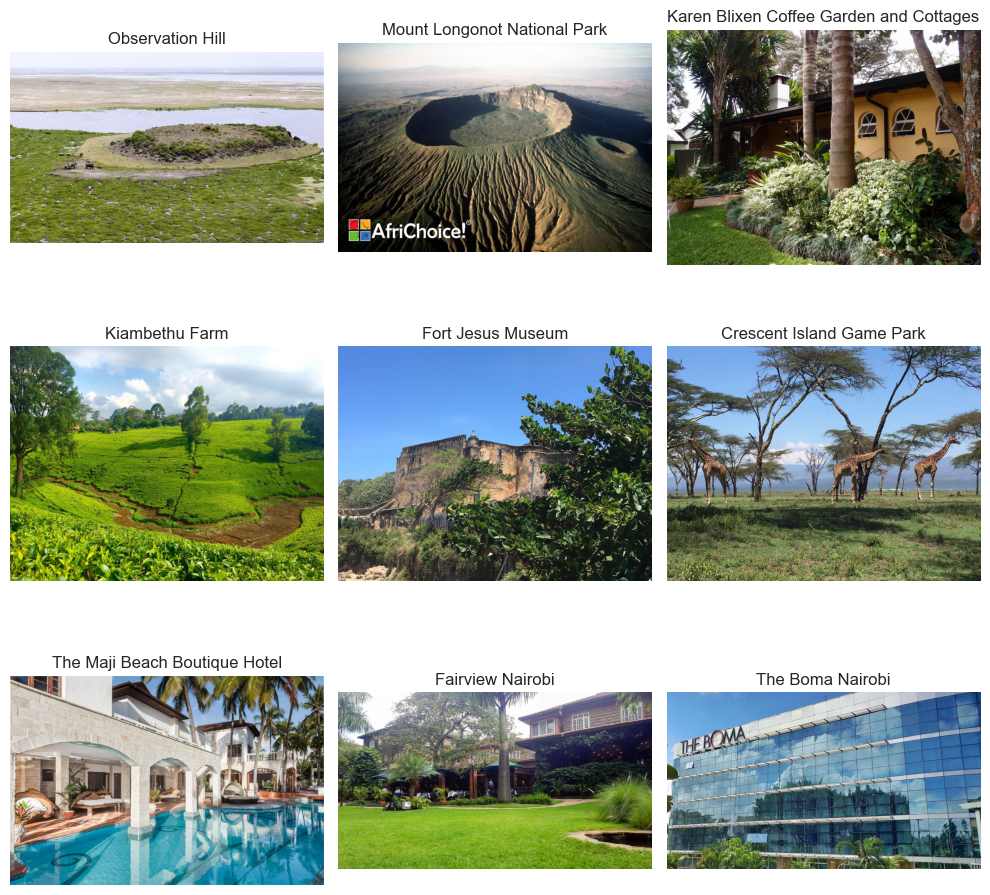

In [21]:
import requests
from PIL import Image
import io
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Extract image URLs
# Load the first 9 images
image_urls = data['image'].tolist()
images = []

# Download images from URLs
for url in image_urls[0:9]:
    try:
        response = requests.get(url)
        if response.status_code == 200:
            img = Image.open(io.BytesIO(response.content))
            images.append(img)
        else:
            images.append(None)  # Append None if the image couldn't be retrieved
    except Exception as e:
        print(f"Error fetching image from {url}: {e}")
        images.append(None)

# Create a 3x3 grid of images
num_rows, num_cols = 3, 3
image_matrix = [[None for _ in range(num_cols)] for _ in range(num_rows)]

for idx, img in enumerate(images):
    row, col = divmod(idx, num_cols)
    if row < num_rows:
        image_matrix[row][col] = img

# Plot the images with labels
fig, axs = plt.subplots(num_rows, num_cols, figsize=(10, 10))
for i in range(num_rows):
    for j in range(num_cols):
        if image_matrix[i][j] is not None:
            axs[i, j].imshow(image_matrix[i][j])
            axs[i, j].set_title(data.loc[i * num_cols + j, 'name'])
        axs[i, j].axis('off')  # Hide axes

plt.tight_layout()
plt.show()

***Review Bigrams Visual***

A visualization of the most common bigrams in the reviews, weighted by the number of reviews, can be useful for the tour recommendation system to find the most popular words used in the reviews.

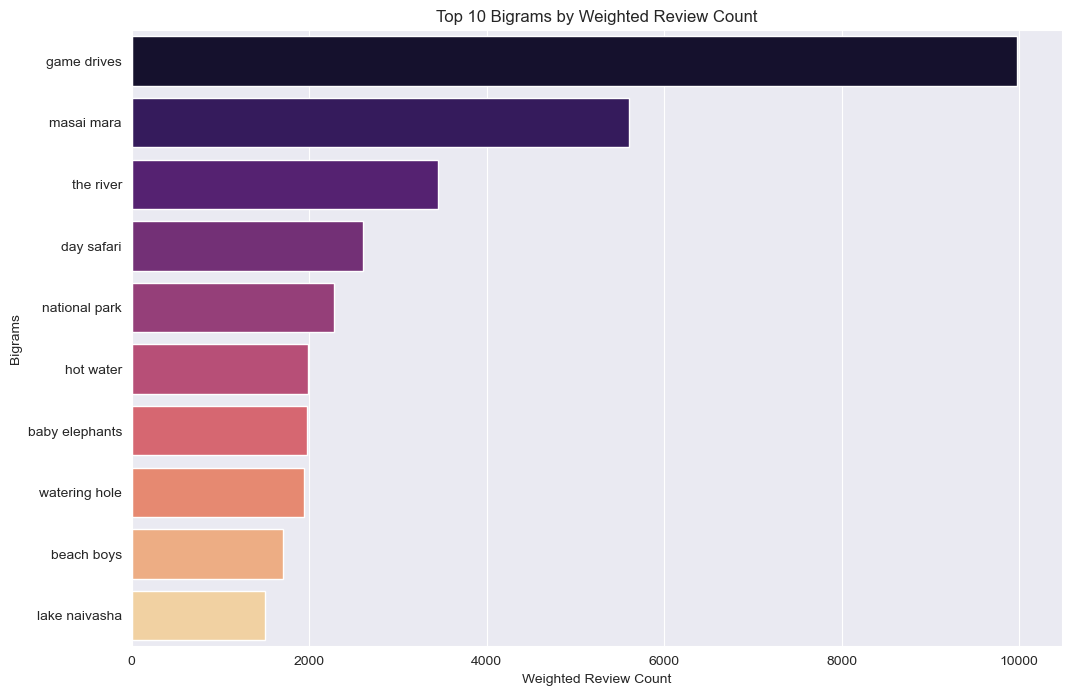

In [22]:
# Tokenize texts into bigrams and count frequencies
import nltk
from nltk.util import bigrams
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

# Tokenize texts into bigrams and count frequencies
def get_bigrams(texts, reviews):
    bigram_counts = Counter()
    for text, review in zip(texts, reviews):
        tokens = nltk.word_tokenize(text)
        bigrams_list = list(bigrams(tokens))
        for bigram in bigrams_list:
            bigram_counts[bigram] += review
    return bigram_counts

data['bigram_counts'] = data.apply(lambda row: get_bigrams(row['texts'], row['reviews']), axis=1)

# Flatten the bigrams into a single string for vectorization
def flatten_bigrams(bigram_counts):
    flattened_text = []
    for bigram, count in bigram_counts.items():
        flattened_text.extend([' '.join(bigram)] * count)
    return ' '.join(flattened_text)

data['flattened_bigrams'] = data['bigram_counts'].apply(flatten_bigrams)

# Aggregate bigram counts across all rows
total_bigram_counts = Counter()
for counts in data['bigram_counts']:
    total_bigram_counts.update(counts)

# Get the most common bigrams
most_common_bigrams = total_bigram_counts.most_common(10)
bigram_labels, bigram_values = zip(*most_common_bigrams)

# Convert tuples to strings for labels
bigram_labels = [' '.join(bigram) for bigram in bigram_labels]

# Create DataFrame for plotting
plot_data = pd.DataFrame({'Bigram': bigram_labels, 'Count': bigram_values})

# Visualize the word counts
plt.figure(figsize=(12, 8))
sns.barplot(x='Count', y='Bigram', data=plot_data, palette='magma')
plt.xlabel('Weighted Review Count')
plt.ylabel('Bigrams')
plt.title('Top 10 Bigrams by Weighted Review Count')
plt.show()

*Extract the main bigram that describes the destinations*

In [23]:
# Function to extract the bigram with the highest frequency
def extract_main_bigram(counter):
    if not counter:  # Check if the Counter is empty
        return None
    return max(counter, key=counter.get)

# Apply the function to create the new column
data['main_bigram'] = data['bigram_counts'].apply(extract_main_bigram)

In [24]:
# Limit the bigram counts further
top_n = 50  # Further reduce the number of bigrams
limited_bigram_frequencies = dict(total_bigram_counts.most_common(top_n))
print(f"Number of bigrams: {len(limited_bigram_frequencies)}")
print(f"Memory usage: {sum([len(str(k)) + len(str(v)) for k, v in limited_bigram_frequencies.items()]) / (1024 * 1024):.2f} MB")
import gc

# Clear variables
del total_bigram_counts
gc.collect()


Number of bigrams: 50
Memory usage: 0.00 MB


4110

***Word Cloud Visual***

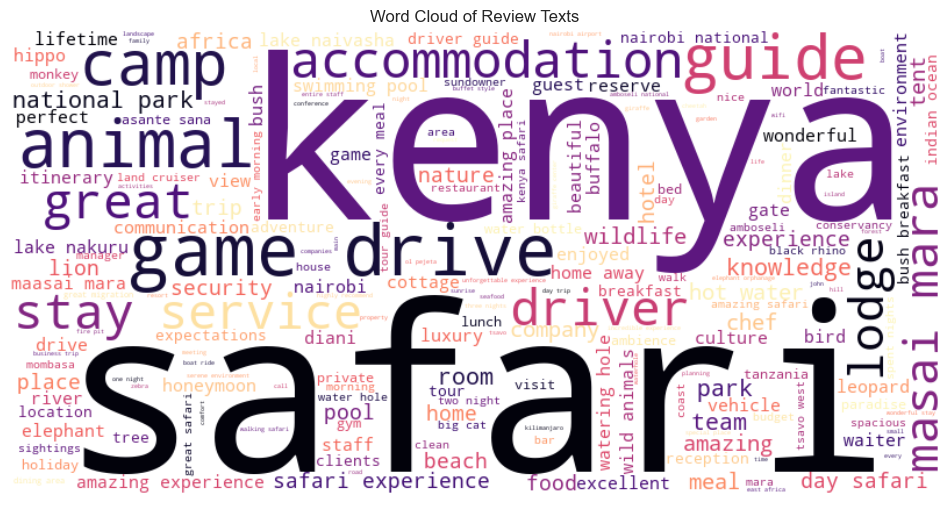

In [25]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Combine all texts into a single string
combined_texts = ' '.join(' '.join(texts) for texts in data['texts'])

# Create a word cloud object
wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='magma').generate(combined_texts)

# Plot the word cloud
plt.figure(figsize=(12, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Review Texts')
plt.show()


### Summary of Key Themes

- **Safari and Wildlife:** The dominant theme is wildlife experiences, highlighted by terms like "safari," "wildlife," "animals," "game drive," and specific animals such as lion, elephant, and giraffe. This suggests a strong emphasis on safari and wildlife activities.

- **Accommodation and Service:** Key terms include "lodge," "camp," "hotel," "service," and "staff," reflecting a focus on guest accommodation and overall service quality.

- **Location:** Geographic terms such as "Masai Mara," "Lake Naivasha," "Kenya," and "Nairobi" underscore the regional focus of the reviews.

- **Positive Sentiment:** Words like "amazing," "great," "beautiful," and "wonderful" point to an overall positive sentiment towards the reviewed experiences.

### Overall Sentiment

- **Positive Sentiment:** Words like "amazing," "great," "beautiful," and "enjoyable" are prevalent across multiple word clouds, suggesting overall positive sentiment towards the locations.
- **Nature and Wildlife:** Words associated with nature, wildlife, and outdoor activities (e.g., "park," "safari," "wildlife," "forest") are prominent, indicating a strong focus on natural experiences.
- **Historical and Cultural Aspects:** Words like “slave,” “trade,” and “colonialism” may point to historical or cultural themes.The presence of “interesting,” “history,” and “culture” suggests educational or informative content.


### ***Univariate Analysis***

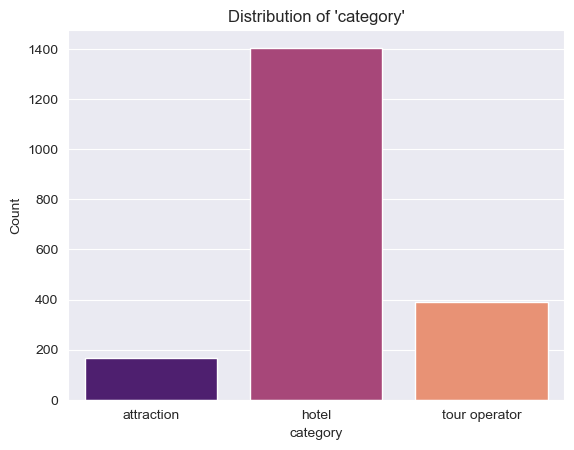

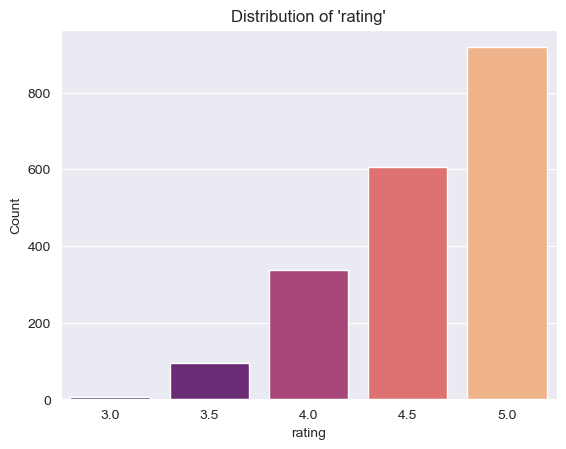

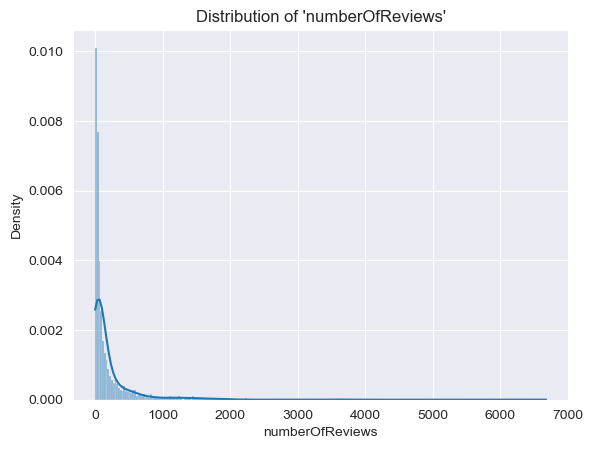

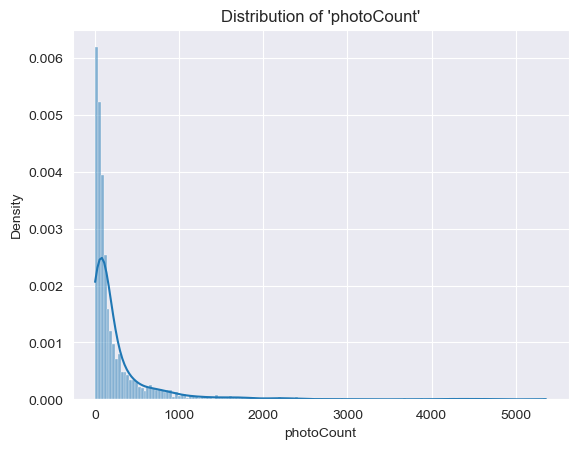

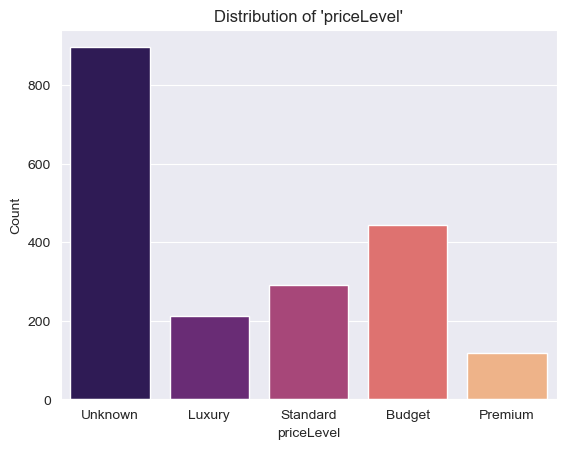

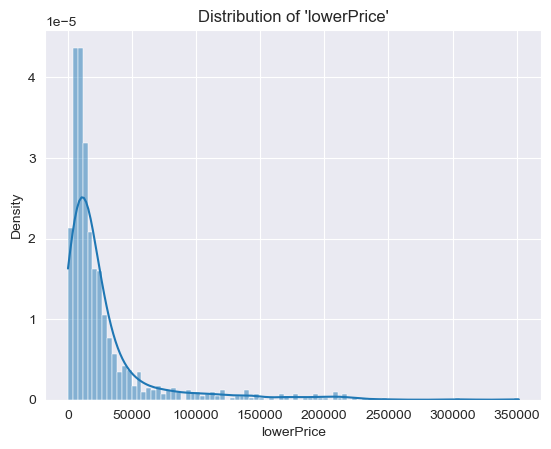

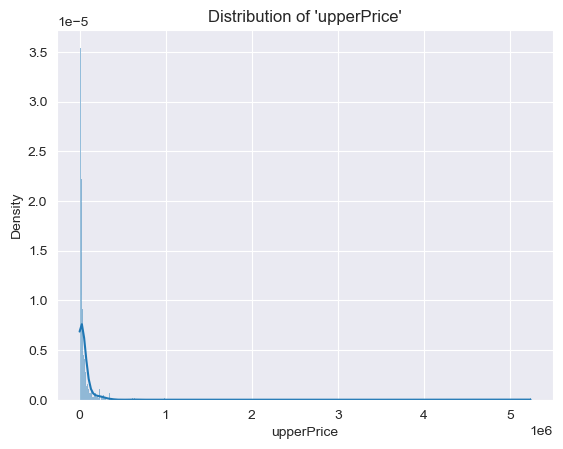

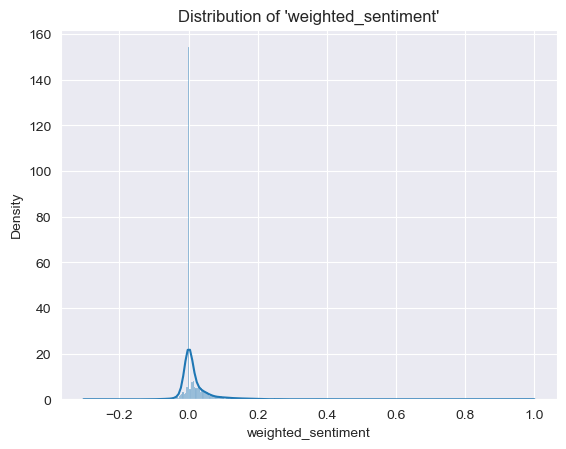

In [26]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def plot_distribution(data, exclude_columns=[]):
    for col in data.columns:
        # Skip the column if it's in the exclude_columns list
        if col in exclude_columns:
            continue
        
        if data[col].dtype == 'object' or data[col].nunique() < 20:
            # If the column is categorical or has less than 20 unique values, use countplot
            custom_palette = 'magma'
            sns.countplot(data=data, x=col, palette=custom_palette)
            plt.title(f"Distribution of '{col}'")
            plt.xlabel(col)
            plt.ylabel('Count')
            plt.xticks()
            plt.show()
        elif pd.api.types.is_numeric_dtype(data[col]):
            # Plot histogram with KDE for numerical columns
            sns.histplot(data[col], kde=True, stat="density")
            plt.title(f"Distribution of '{col}'")
            plt.xlabel(col)
            plt.ylabel('Density')
            plt.show()

# Example usage
exclude = ['name', 'image', 'priceRange', 'reviewTags', 'photos', 'reviews', 'texts', 'adjusted_sentiment',
           'bigram_counts', 'main_bigram', 'location', 'province', 'locationString', 'flattened_bigrams']
plot_distribution(data, exclude_columns=exclude)


### ***Correlation Analysis***

Label encode the priceLevel so as to perform a correlation analysis.

In [27]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
data['priceLevelencoded'] = label_encoder.fit_transform(data['priceLevel'])


The following columns were dropped due to being object types:
['name', 'category', 'image', 'priceRange', 'reviewTags', 'priceLevel', 'locationString', 'texts', 'reviews', 'location', 'province', 'bigram_counts', 'flattened_bigrams', 'main_bigram']


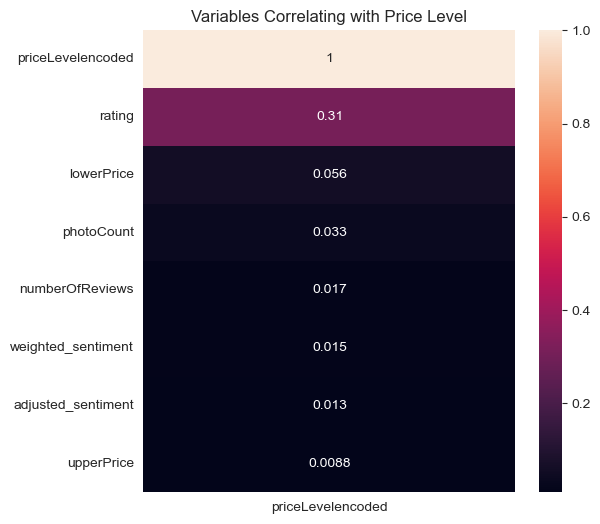

In [28]:
def correlation(df,column=None,rank=None):
    '''
    performs correlation matrix, drops non numeric object types
    variables are dataframe, column, and ranking
    ranking is optional
    column = 'column'
    rank = True for # rank 1,2,3...
    
    '''
    # Redundant check. Makes sure all columns of object type are dropped
    df_object = df.select_dtypes(include='object')
    print(f'The following columns were dropped due to being object types:\n{df_object.columns.tolist()}')
    df = df.drop(df_object,axis=1) 
    df1 = df
    if rank is True:
        try:
            df_corr = df1.corr()[column]
            df_corr = df_corr.drop(column)
            print(f'Ranked correlation to {column}')
            return(df_corr.rank(ascending=False).sort_values())
        except:
            df_corr = df1.corr()
            return(df_corr.rank(ascending=False))
    else:    
        try:
            df_corr = df.corr()[column]
            df_corr = df_corr.drop(column)
            print(f'Correlation to {column}')
            return(df_corr.sort_values(ascending=False))
        except:
            df_corr = df1.corr()
            return(df_corr)

# Getting the correlation between variables
df_corr = abs(correlation(data))
fig, ax = plt.subplots(figsize=(6,6))
sns.heatmap(df_corr[['priceLevelencoded']].sort_values(by='priceLevelencoded',ascending=False),annot = True)

ax.set_title('Variables Correlating with Price Level');
# plt.savefig('Group_plots/correlation_plot.png', dpi=100)

In [29]:
# Correlation matrix
correlation_matrix = data[['rating', 'numberOfReviews', 'lowerPrice', 'upperPrice', 'weighted_sentiment', 'adjusted_sentiment']].corr()
correlation_matrix


,rating,numberOfReviews,lowerPrice,upperPrice,weighted_sentiment,adjusted_sentiment
rating,1.000000,-0.066038,0.376862,0.138598,-0.053227,-0.053412
numberOfReviews,-0.066038,1.000000,0.114381,0.030369,0.003279,-0.006440
lowerPrice,0.376862,0.114381,1.000000,0.329648,-0.123438,-0.144134
upperPrice,0.138598,0.030369,0.329648,1.000000,0.071007,0.056691
weighted_sentiment,-0.053227,0.003279,-0.123438,0.071007,1.000000,0.983304
adjusted_sentiment,-0.053412,-0.006440,-0.144134,0.056691,0.983304,1.000000


### ***Top 10 Locations***

In [30]:
# Calculate the top 10 names based on average rating
top_10_names = data.groupby('name').agg({'rating': 'mean', 'category': 'first'}).nlargest(10, 'rating')

# Reset index to get 'name' as a column
top_10_names = top_10_names.reset_index()

# Display the table
print("Top 10 Names by Average Rating:")
top_10_names[['name', 'rating', 'category']]

Top 10 Names by Average Rating:


,name,rating,category
0,A Rocha Eco-Lodge & Conservation Centre,5.0,hotel
1,ACROSS WILDERNESS EXPEDITION,5.0,tour operator
2,APODIFORMES ADVENTURES,5.0,tour operator
3,Abdull Safari Kenya,5.0,tour operator
4,Absolute Vantage Limited,5.0,attraction
5,Acacia Tree Lodge,5.0,hotel
6,Ace Ecotours,5.0,tour operator
7,Ack Guest-House Machakos,5.0,hotel
8,Across The Wild Tours & Safaris,5.0,tour operator
9,Adventure 360,5.0,tour operator


### ***Bivariate Analysis***

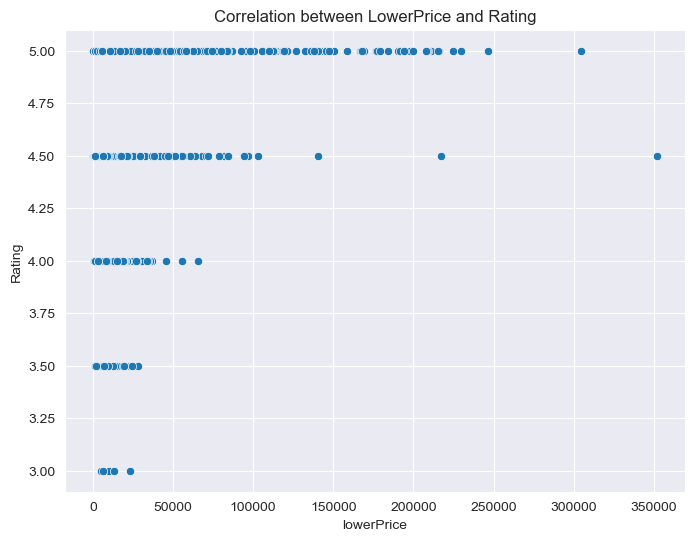

In [31]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=data['lowerPrice'], y=data['rating'])
plt.title('Correlation between LowerPrice and Rating')
plt.xlabel('lowerPrice')
plt.ylabel('Rating')
plt.show()

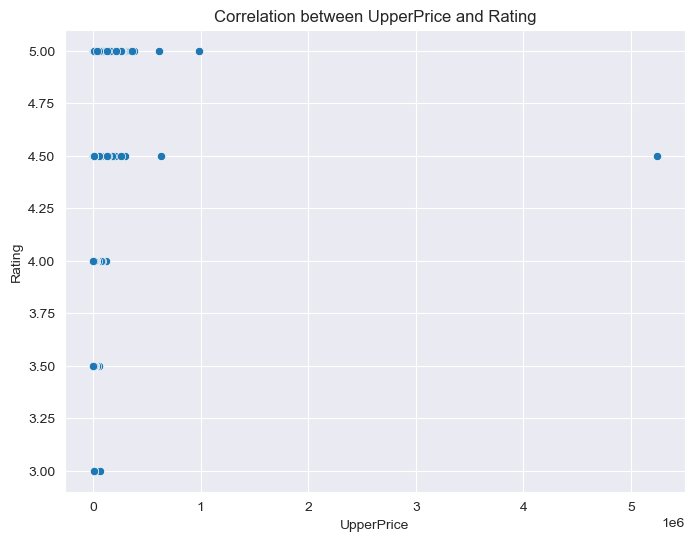

In [32]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=data['upperPrice'], y=data['rating'])
plt.title('Correlation between UpperPrice and Rating')
plt.xlabel('UpperPrice')
plt.ylabel('Rating')
plt.show()

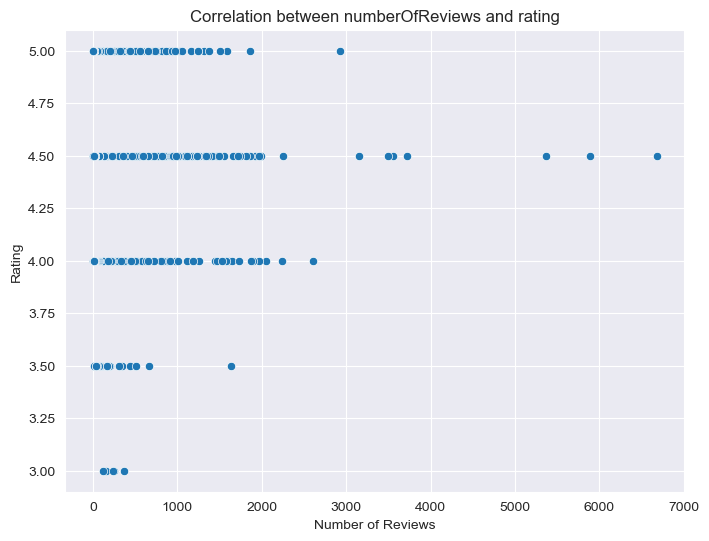

In [33]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=data['numberOfReviews'], y=data['rating'])
plt.title('Correlation between numberOfReviews and rating')
plt.xlabel('Number of Reviews')
plt.ylabel('Rating')
plt.show()

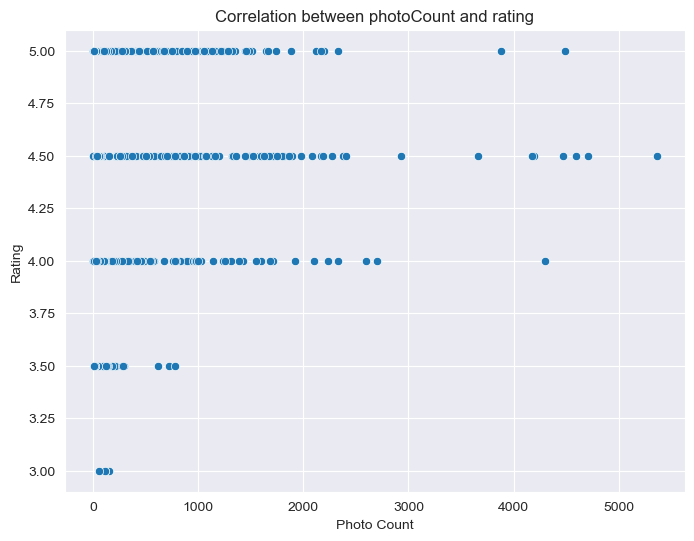

In [34]:

plt.figure(figsize=(8, 6))
sns.scatterplot(x=data['photoCount'], y=data['rating'])
plt.title('Correlation between photoCount and rating')
plt.xlabel('Photo Count')
plt.ylabel('Rating')
plt.show()



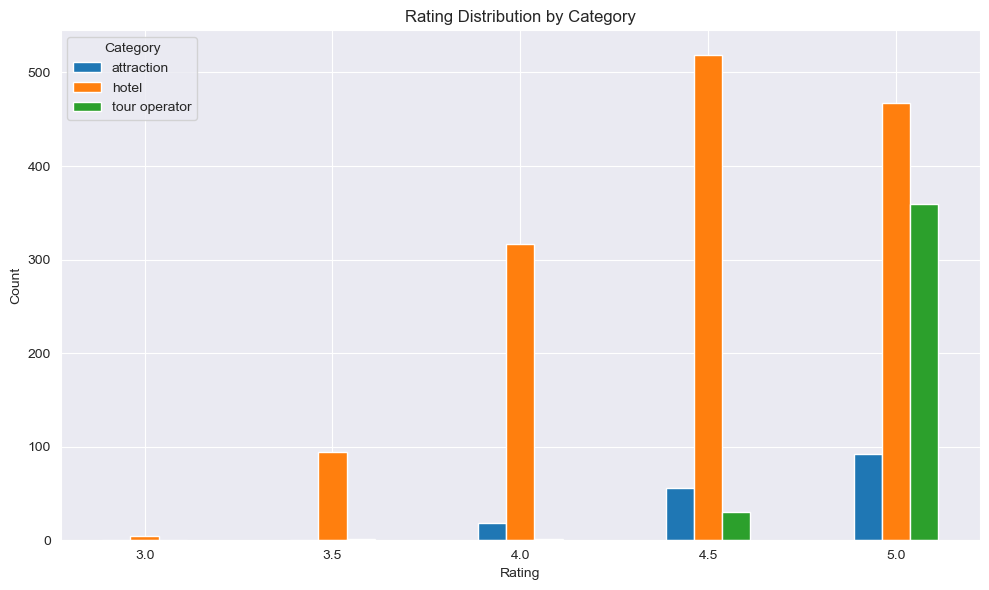

In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

grouped_data = data.groupby('category')['rating'].value_counts().unstack().fillna(0)

# Get unique categories and ratings
categories = data['category'].unique()
ratings = grouped_data.columns

# Set the width of each bar
bar_width = 0.15

# Calculate the x position for each group of bars
x = np.arange(len(ratings))

# Create subplots
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the bars for each category within each rating
for i, category in enumerate(categories):
    ax.bar(x + (i * bar_width), grouped_data.loc[category], width=bar_width, label=category)

# Set the x-axis labels and ticks
ax.set_xticks(x + ((len(categories) - 1) * bar_width) / 2)
ax.set_xticklabels(ratings)
ax.set_xlabel('Rating')
ax.set_ylabel('Count')
ax.set_title('Rating Distribution by Category')
ax.legend(title='Category')

# Adjust the layout
plt.tight_layout()

# Show the plot
plt.show()


- **Higher Ratings for Attractions:** Attractions generally received higher ratings, with a larger number of ratings at 4.5 and 5.0 compared to hotels. This suggests that customers are more satisfied with attractions.

- **Bimodal Distribution for Hotels:** Hotel ratings show a bimodal distribution with peaks around 3.5 and 4.5. This indicates a split in customer experiences, with some customers being highly satisfied while others are less so.


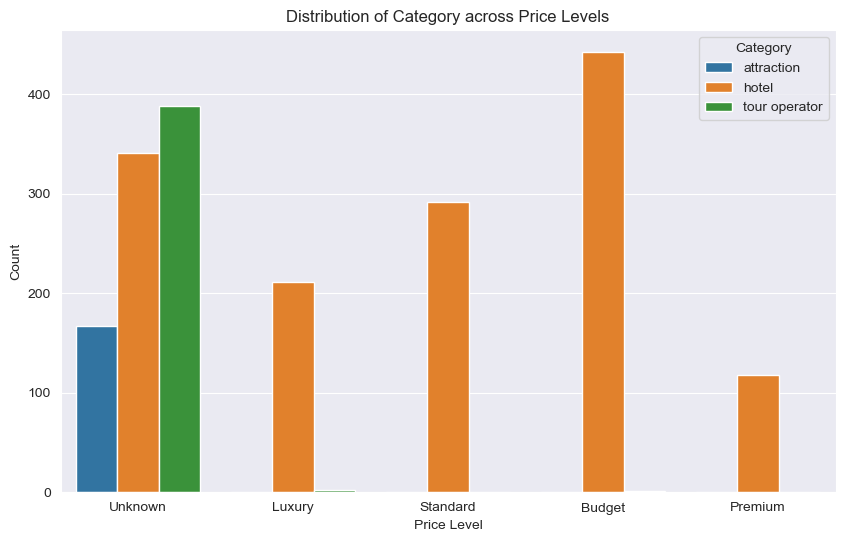

In [36]:

plt.figure(figsize=(10, 6))
sns.countplot(data=data, x='priceLevel', hue='category')
plt.title('Distribution of Category across Price Levels')
plt.xlabel('Price Level')
plt.ylabel('Count')
plt.legend(title='Category')
plt.show()

In [37]:
combined_table = data.groupby(['category', 'priceLevel']).agg(
    avg_rating=('rating', 'mean'),
    total_reviews=('numberOfReviews', 'sum'),
    avg_photo_count=('photoCount', 'mean')
).reset_index()

combined_table

,category,priceLevel,avg_rating,total_reviews,avg_photo_count
0,attraction,Unknown,4.722892,61325,399.922156
1,hotel,Budget,4.310658,39159,86.015837
2,hotel,Luxury,4.800948,74561,518.521327
3,hotel,Premium,4.483051,53793,553.347458
4,hotel,Standard,4.400344,97126,318.373288
5,hotel,Unknown,4.571848,31126,138.906158
6,tour operator,Budget,4.500000,7,7.000000
7,tour operator,Luxury,5.000000,519,364.500000
8,tour operator,Unknown,4.956186,49462,218.546392


### Summary
The attraction category lacks price data and this presents a challenge. We will handle the issue by creating separate models for each category.

We will build two different recommendation models: one for attractions and one for hotels. Since attractions don’t have price data, we will exclude priceLevel from the model for attractions and focus on other features like rating and reviews.

This approach will allow tailoring the recommendation model specifically to the available data for each category.

In [38]:
# data.to_csv('C:/Users/Hp/Documents/DATA_SCIENCE/MORINGA/PHASE_5-Final_Project/SafariHub/data.csv', index=False)

# ***Modeling***

Encode the `location`, `province` and `category` columns so as to fit them into the models.

In [39]:
label_encoder = LabelEncoder()
data['location_encoded'] = label_encoder.fit_transform(data['location'])
data['province_encoded'] = label_encoder.fit_transform(data['province'])
data['category_encoded'] = label_encoder.fit_transform(data['category'])

Split the data into categories so as to work with the different requirements.
This is to avoid dropping rows that don't have price values.

In [40]:
# Filter the rows where the 'category' is 'attraction'
attraction_data = data[data['category'] == 'attraction'][[
    'name', 'category', 'rating', 'numberOfReviews', 'photoCount','category_encoded',
    'reviewTags', 'priceLevel', 'texts', 'reviews', 'weighted_sentiment', 'adjusted_sentiment',
    'bigram_counts', 'priceLevelencoded', 'location_encoded', 'province_encoded', 'flattened_bigrams'
]]

# Filter the rows where the 'category' is 'hotel'
hotel_data = data[data['category'] == 'hotel'][[
    'name', 'category', 'rating', 'numberOfReviews', 'photoCount','category_encoded',
    'priceRange', 'reviewTags', 'priceLevel', 'texts', 'reviews',
    'lowerPrice', 'upperPrice', 'weighted_sentiment', 'adjusted_sentiment',
    'bigram_counts', 'priceLevelencoded', 'location_encoded', 'province_encoded', 'flattened_bigrams'
]]

# Filter the rows where the 'category' is 'tours'
tours_data = data[data['category'] == 'tour operator'][[
    'name', 'category', 'rating', 'numberOfReviews', 'photoCount','category_encoded',
    'reviewTags', 'priceLevel', 'texts', 'reviews', 'weighted_sentiment', 'adjusted_sentiment',
    'bigram_counts', 'priceLevelencoded', 'location_encoded', 'province_encoded', 'flattened_bigrams'
]]

In [41]:
print(attraction_data.shape)
print(hotel_data.shape)
print(tours_data.shape)

(167, 17)
(1404, 20)
(391, 17)


Drop null values

In [ ]:
attraction_data = attraction_data.dropna()
attraction_data.reset_index(drop=True, inplace=True)
print(attraction_data.shape)
hotel_data = hotel_data.dropna()
hotel_data.reset_index(drop=True, inplace=True)
print(hotel_data.shape)
tours_data = tours_data.dropna()
tours_data.reset_index(drop=True, inplace=True)
print(tours_data.shape)

(166, 17)

## Model 1

#### Attraction destination predictor

In [55]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Vectorization
# Initialize CountVectorizer to vectorize the flattened bigrams
vectorizer = CountVectorizer()
bigram_matrix = vectorizer.fit_transform(attraction_data['flattened_bigrams'])

# Now, bigram_matrix contains the vectorized representation of the bigrams
# Combine this with other features as needed
# Select the features and the tour names
X = attraction_data[['category_encoded', 'rating', 'numberOfReviews', 'photoCount', 'adjusted_sentiment',
           'location_encoded', 'province_encoded', 'priceLevelencoded']]

names = attraction_data['name']


# Convert numeric features to array and stack with bigram matrix
numeric_matrix = X.values
combined_features = np.hstack((X, bigram_matrix.toarray()))

# Scale the combined features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(combined_features)

# Split the data into training and testing sets
X_train, X_test, names_train, names_test = train_test_split(X_scaled, names, test_size=0.2, random_state=42)

# Initialize and fit the KNN model on training data
knn = NearestNeighbors(n_neighbors=5, metric='cosine')
knn.fit(X_train)

def recommend_attractions(tour_name, top_n=5):
    """
    Recommend attractions similar to a given tour name.
    
    Parameters:
    - tour_name: The name of the tour selected by the user.
    - top_n: The number of similar attractions to recommend.
    
    Returns:
    - recommended_names: List of recommended attraction names.
    - distances: List of distances of the recommended attractions.
    """
    # Find the index of the given tour name
    tour_idx = names_train[names_train == tour_name].index[0]
    
    # Find the nearest neighbors in the training set
    distances, indices = knn.kneighbors([X_train[tour_idx]], n_neighbors=top_n+1)  # +1 to include the query itself
    
    # Get the recommended attractions, excluding the query itself
    recommended_names = names_train.iloc[indices.flatten()[1:]].values
    return recommended_names, distances.flatten()[1:]

# Test the Recommendation Function
example_tour_name = names_train.iloc[96]  # Just taking the first tour in the training set as an example
recommended_names, distances = recommend_attractions(example_tour_name)
print("Recommended attractions:", recommended_names)
print("Distances:", distances)

def evaluate_recommendations(knn_model, X_test, names_test, top_n=5):
    """
    Evaluate the KNN model by predicting the most similar attractions for the test set
    and calculating metrics like RMSE, MAE, Accuracy, Precision, Recall, and F1 Score.
    """
    total_mse, total_mae, count = 0, 0, 0
    all_true_labels = []
    all_pred_labels = []
    
    for idx, test_sample in enumerate(X_test):
        # Get the true name for this test sample
        true_name = names_test.iloc[idx]
        
        # Predict the closest neighbors for the test sample
        distances, indices = knn_model.kneighbors([test_sample], n_neighbors=top_n)
        
        # Check if the true name is in the recommended names
        recommended_names = names_train.iloc[indices.flatten()].values
        true_labels = [1 if name == true_name else 0 for name in recommended_names]
        
        # Consider the highest ranked recommendation as the predicted label
        pred_labels = [1 if i == 0 else 0 for i in range(top_n)]
        
        # Accumulate metrics
        all_true_labels.extend(true_labels)
        all_pred_labels.extend(pred_labels)
        
        # Calculate distance metrics (using the distance as an approximation of similarity)
        mse = np.mean(distances**2)
        mae = np.mean(distances)
        
        total_mse += mse
        total_mae += mae
        count += 1
    
    avg_mse = total_mse / count
    avg_rmse = np.sqrt(avg_mse)
    avg_mae = total_mae / count
    
    print(f"Average Mean Squared Error (MSE): {avg_mse}")
    print(f"Average Root Mean Squared Error (RMSE): {avg_rmse}")
    print(f"Average Mean Absolute Error (MAE): {avg_mae}")
    
    # Calculate classification metrics
    accuracy = accuracy_score(all_true_labels, all_pred_labels)
    precision = precision_score(all_true_labels, all_pred_labels)
    recall = recall_score(all_true_labels, all_pred_labels)
    f1 = f1_score(all_true_labels, all_pred_labels)
    
    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1}")

# Run the evaluation
evaluate_recommendations(knn, X_test, names_test, top_n=5)


Recommended attractions: ['Motherland Diaries' 'Wild Voyager' 'Live Kenya Con Prezzemolo'
 'Benson Kungu  Jungleman' 'Moyo Casino']
Distances: [0.00044004 0.0005087  0.00590264 0.02304691 0.08148652]
Average Mean Squared Error (MSE): 0.590111855481678
Average Root Mean Squared Error (RMSE): 0.7681873830529098
Average Mean Absolute Error (MAE): 0.674297832005829
Accuracy: 0.8
Precision: 0.0
Recall: 0.0
F1 Score: 0.0


#### Hotel predictor

In [56]:

# Vectorization
# Initialize CountVectorizer to vectorize the flattened bigrams
vectorizer = CountVectorizer()
bigram_matrix = vectorizer.fit_transform(hotel_data['flattened_bigrams'])

# Now, bigram_matrix contains the vectorized representation of the bigrams
# Combine this with other features as needed
# Select the features and the tour names
X = hotel_data[['category_encoded', 'rating', 'numberOfReviews', 'photoCount', 'adjusted_sentiment',
           'location_encoded', 'province_encoded', 'priceLevelencoded', 'upperPrice', 'lowerPrice']]

names = hotel_data['name']


# Convert numeric features to array and stack with bigram matrix
numeric_matrix = X.values
combined_features = np.hstack((X, bigram_matrix.toarray()))

# Scale the combined features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(combined_features)

# Split the data into training and testing sets
X_train, X_test, names_train, names_test = train_test_split(X_scaled, names, test_size=0.2, random_state=42)

# Initialize and fit the KNN model on training data
knn = NearestNeighbors(n_neighbors=5, metric='cosine')
knn.fit(X_train)

def recommend_attractions(tour_name, top_n=5):
    """
    Recommend attractions similar to a given tour name.
    
    Parameters:
    - tour_name: The name of the tour selected by the user.
    - top_n: The number of similar attractions to recommend.
    
    Returns:
    - recommended_names: List of recommended attraction names.
    - distances: List of distances of the recommended attractions.
    """
    # Find the index of the given tour name
    tour_idx = names_train[names_train == tour_name].index[0]
    
    # Find the nearest neighbors in the training set
    distances, indices = knn.kneighbors([X_train[tour_idx]], n_neighbors=top_n+1)  # +1 to include the query itself
    
    # Get the recommended attractions, excluding the query itself
    recommended_names = names_train.iloc[indices.flatten()[1:]].values
    return recommended_names, distances.flatten()[1:]

# Test the Recommendation Function
example_tour_name = names_train.iloc[96]  # Just taking the first tour in the training set as an example
recommended_names, distances = recommend_attractions(example_tour_name)
print("Recommended attractions:", recommended_names)
print("Distances:", distances)

def evaluate_recommendations(knn_model, X_test, names_test, top_n=5):
    """
    Evaluate the KNN model by predicting the most similar attractions for the test set
    and calculating metrics like RMSE, MAE, Accuracy, Precision, Recall, and F1 Score.
    """
    total_mse, total_mae, count = 0, 0, 0
    all_true_labels = []
    all_pred_labels = []
    
    for idx, test_sample in enumerate(X_test):
        # Get the true name for this test sample
        true_name = names_test.iloc[idx]
        
        # Predict the closest neighbors for the test sample
        distances, indices = knn_model.kneighbors([test_sample], n_neighbors=top_n)
        
        # Check if the true name is in the recommended names
        recommended_names = names_train.iloc[indices.flatten()].values
        true_labels = [1 if name == true_name else 0 for name in recommended_names]
        
        # Consider the highest ranked recommendation as the predicted label
        pred_labels = [1 if i == 0 else 0 for i in range(top_n)]
        
        # Accumulate metrics
        all_true_labels.extend(true_labels)
        all_pred_labels.extend(pred_labels)
        
        # Calculate distance metrics (using the distance as an approximation of similarity)
        mse = np.mean(distances**2)
        mae = np.mean(distances)
        
        total_mse += mse
        total_mae += mae
        count += 1
    
    avg_mse = total_mse / count
    avg_rmse = np.sqrt(avg_mse)
    avg_mae = total_mae / count
    
    print(f"Average Mean Squared Error (MSE): {avg_mse}")
    print(f"Average Root Mean Squared Error (RMSE): {avg_rmse}")
    print(f"Average Mean Absolute Error (MAE): {avg_mae}")
    
    # Calculate classification metrics
    accuracy = accuracy_score(all_true_labels, all_pred_labels)
    precision = precision_score(all_true_labels, all_pred_labels)
    recall = recall_score(all_true_labels, all_pred_labels)
    f1 = f1_score(all_true_labels, all_pred_labels)
    
    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1}")

# Run the evaluation
evaluate_recommendations(knn, X_test, names_test, top_n=5)


Recommended attractions: ['Comfort Gardens' "Brownie's The Haven" 'Maralal - Ngari Hill Guesthouse'
 'Bilashaka Lodge' 'Myra Residences']
Distances: [0.00016689 0.00120015 0.0182449  0.0291502  0.03193053]
Average Mean Squared Error (MSE): 0.3312374846464736
Average Root Mean Squared Error (RMSE): 0.5755323489140064
Average Mean Absolute Error (MAE): 0.41561299263145446
Accuracy: 0.8
Precision: 0.0
Recall: 0.0
F1 Score: 0.0


#### Tour Operator predictor

In [57]:
# Vectorization
# Initialize CountVectorizer to vectorize the flattened bigrams
vectorizer = CountVectorizer()
bigram_matrix = vectorizer.fit_transform(tours_data['flattened_bigrams'])

# Now, bigram_matrix contains the vectorized representation of the bigrams
# Combine this with other features as needed
# Select the features and the tour names
X = tours_data[['category_encoded', 'rating', 'numberOfReviews', 'photoCount', 'adjusted_sentiment',
           'location_encoded', 'province_encoded', 'priceLevelencoded']]

names = tours_data['name']


# Convert numeric features to array and stack with bigram matrix
numeric_matrix = X.values
combined_features = np.hstack((X, bigram_matrix.toarray()))

# Scale the combined features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(combined_features)

# Split the data into training and testing sets
X_train, X_test, names_train, names_test = train_test_split(X_scaled, names, test_size=0.2, random_state=42)

# Initialize and fit the KNN model on training data
knn = NearestNeighbors(n_neighbors=5, metric='cosine')
knn.fit(X_train)

def recommend_attractions(tour_name, top_n=5):
    """
    Recommend attractions similar to a given tour name.
    
    Parameters:
    - tour_name: The name of the tour selected by the user.
    - top_n: The number of similar attractions to recommend.
    
    Returns:
    - recommended_names: List of recommended attraction names.
    - distances: List of distances of the recommended attractions.
    """
    # Find the index of the given tour name
    tour_idx = names_train[names_train == tour_name].index[0]
    
    # Find the nearest neighbors in the training set
    distances, indices = knn.kneighbors([X_train[tour_idx]], n_neighbors=top_n+1)  # +1 to include the query itself
    
    # Get the recommended attractions, excluding the query itself
    recommended_names = names_train.iloc[indices.flatten()[1:]].values
    return recommended_names, distances.flatten()[1:]

# Test the Recommendation Function
example_tour_name = names_train.iloc[96]  # Just taking the first tour in the training set as an example
recommended_names, distances = recommend_attractions(example_tour_name)
print("Recommended attractions:", recommended_names)
print("Distances:", distances)

def evaluate_recommendations(knn_model, X_test, names_test, top_n=5):
    """
    Evaluate the KNN model by predicting the most similar attractions for the test set
    and calculating metrics like RMSE, MAE, Accuracy, Precision, Recall, and F1 Score.
    """
    total_mse, total_mae, count = 0, 0, 0
    all_true_labels = []
    all_pred_labels = []
    
    for idx, test_sample in enumerate(X_test):
        # Get the true name for this test sample
        true_name = names_test.iloc[idx]
        
        # Predict the closest neighbors for the test sample
        distances, indices = knn_model.kneighbors([test_sample], n_neighbors=top_n)
        
        # Check if the true name is in the recommended names
        recommended_names = names_train.iloc[indices.flatten()].values
        true_labels = [1 if name == true_name else 0 for name in recommended_names]
        
        # Consider the highest ranked recommendation as the predicted label
        pred_labels = [1 if i == 0 else 0 for i in range(top_n)]
        
        # Accumulate metrics
        all_true_labels.extend(true_labels)
        all_pred_labels.extend(pred_labels)
        
        # Calculate distance metrics (using the distance as an approximation of similarity)
        mse = np.mean(distances**2)
        mae = np.mean(distances)
        
        total_mse += mse
        total_mae += mae
        count += 1
    
    avg_mse = total_mse / count
    avg_rmse = np.sqrt(avg_mse)
    avg_mae = total_mae / count
    
    print(f"Average Mean Squared Error (MSE): {avg_mse}")
    print(f"Average Root Mean Squared Error (RMSE): {avg_rmse}")
    print(f"Average Mean Absolute Error (MAE): {avg_mae}")
    
    # Calculate classification metrics
    accuracy = accuracy_score(all_true_labels, all_pred_labels)
    precision = precision_score(all_true_labels, all_pred_labels)
    recall = recall_score(all_true_labels, all_pred_labels)
    f1 = f1_score(all_true_labels, all_pred_labels)
    
    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1}")

# Run the evaluation
evaluate_recommendations(knn, X_test, names_test, top_n=5)


Recommended attractions: ['Eddison Safari Kenya' 'Watamu Diego Safari Day Tours'
 'Safari Karibuni con derick frigorifero' 'Juma Safari Kenya'
 'Safaris Kenya con Gallo']
Distances: [0.00109146 0.00168732 0.00185976 0.00194484 0.00336561]
Average Mean Squared Error (MSE): 0.37279452645558286
Average Root Mean Squared Error (RMSE): 0.6105690185847812
Average Mean Absolute Error (MAE): 0.4550736139671214
Accuracy: 0.8
Precision: 0.0
Recall: 0.0
F1 Score: 0.0
